In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
from sklearn.model_selection import train_test_split


/home/grigoriy/anaconda3/envs/tf1.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/grigoriy/anaconda3/envs/tf1.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/grigoriy/anaconda3/envs/tf1.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/grigoriy/anaconda3/envs/tf1.5/lib/pyt

1.5.0


## Линейная модель

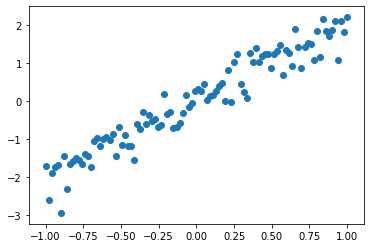

In [2]:
x_train = np.linspace(-1, 1, 100)
y_train = 2 * x_train + np.random.randn(*x_train.shape) * 0.33

plt.scatter(x_train, y_train)
plt.show()

W:2.014, b:0.019


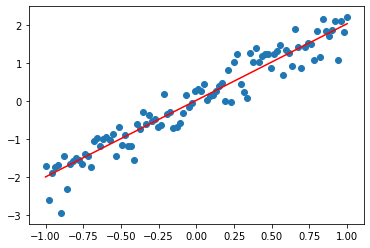

In [13]:
learning_rate = 0.01
training_epochs = 100

X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

def model(X, w, b):
    return  tf.multiply(X, w) + b

w = tf.Variable(0.0, name = 'weights')
b = tf.Variable(0.0, name = 'bias')

y_model = model(X, w, b)
cost = tf.square(Y - y_model) #SE

train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):
        for (x, y) in zip(x_train, y_train):
            sess.run(train_op, feed_dict={X: x, Y:y})
    # Получаем окончательные значения W и b      
    w_val = sess.run(w)
    b_val = sess.run(b)
    print('W:{:.3f}, b:{:.3f}'.format(w_val, b_val))
    
plt.scatter(x_train, y_train)
y_learned = x_train * w_val + b_val
plt.plot(x_train, y_learned, 'r')
plt.show()



## Полиномиальная модель

In [11]:
tf.reset_default_graph()

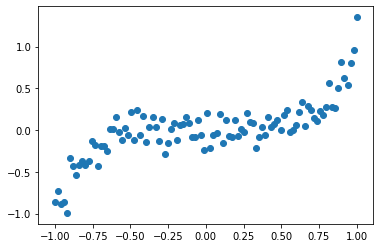

In [12]:
x_train = np.linspace(-1, 1, 100)
y_train = np.power(x_train, 5) + np.random.randn(*x_train.shape) * 0.15

plt.scatter(x_train, y_train)
plt.show()

W:[ 0.03876356 -0.3015552  -0.40846267  1.2504598   0.59313214]


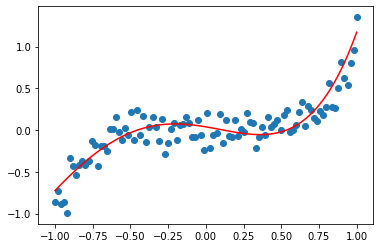

In [15]:
learning_rate = 0.05
training_epochs = 100
num_coeffs = 5

X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

def model(X, w):
    parts = []
    for i in range(num_coeffs):
        part = tf.multiply(w[i], tf.pow(X, i))
        parts.append(part)
    return tf.add_n(parts) #https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/math/add_n

w = tf.Variable([0.] * num_coeffs, name='weights')
y_model = model(X, w)

#cost = tf.reduce_sum(tf.square(Y - y_model))/(2*x_train.size) #RMSE - stronger regularization
cost = tf.square(Y - y_model) # SE
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):
        for (x, y) in zip(x_train, y_train):
            sess.run(train_op, feed_dict={X: x, Y:y})
    # Получаем окончательные значения W и b      
    w_val = sess.run(w)
    print('W:{}'.format(w_val))
    
plt.scatter(x_train, y_train)
y_learned = sum(w_val[i] * np.power(x_train, i) for i in range(num_coeffs))
plt.plot(x_train, y_learned, 'r')
plt.show()


## Регуляризация

In [6]:
tf.reset_default_graph()

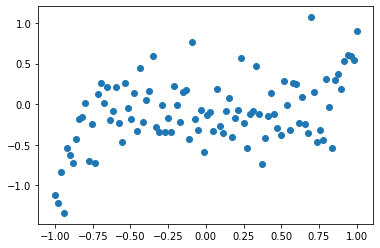

In [7]:
x = np.linspace(-1, 1, 100)
y = np.power(x, 9) + np.random.randn(*x.shape) * 0.3 #Используем полином 9 степени чтобы создать повод для регуляризации

plt.scatter(x, y)
plt.show()

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [16]:
X = tf.placeholder("float")
Y = tf.placeholder("float")

num_coeffs = 9
learning_rate = 0.001
training_epochs = 1000
reg_lambda = 0.

def model(X, w):
    terms = []
    for i in range(num_coeffs):
        term = tf.multiply(w[i], tf.pow(X, i))
        terms.append(term)
    return tf.add_n(terms)

w = tf.Variable([0.] * num_coeffs, name="parameters")
y_model = model(X, w)
cost = tf.div(tf.add(tf.reduce_sum(tf.square(Y-y_model)),
                     tf.multiply(reg_lambda, tf.reduce_sum(tf.square(w)))),
              2*x_train.size) #MSE + l2 norm

train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)



sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

costs = []
for reg_lambda in np.linspace(0,1,100):
    for epoch in range(training_epochs):
        sess.run(train_op, feed_dict={X: x_train, Y: y_train})
    final_cost = sess.run(cost, feed_dict={X: x_test, Y:y_test})
    costs.append(final_cost)
#     print('reg lambda', reg_lambda)
#     print('final cost', final_cost)

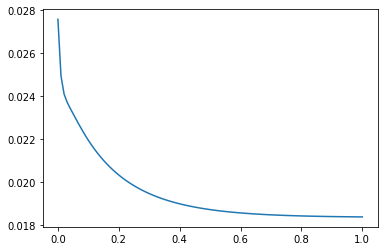

In [20]:
plt.plot(np.linspace(0,1,100), costs)
plt.show()
